In [ ]:
from google.colab import drive
import os
import json
import numpy as np
from PIL import Image
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import cv2
import re
import numpy as np

# Paths to videos and labels
videos_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/labels"

# Load verb (action) mapping from label_mapping.txt
verb_mapping = {}
with open(os.path.join('/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/label_mapping.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):  # skip comments/headers
            continue
        parts = line.split(',')
        triplet_id = int(parts[0])
        verb_id = int(parts[2])  # 3rd column = verb ID (as per CholecT50 format)
        verb_mapping[triplet_id] = verb_id

X = []
Y = []

# Loop through all video folders
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)

    if not os.path.isdir(vid_path):
        continue

    # Corresponding label JSON
    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)

    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    # Load JSON labels
    with open(label_path, 'r') as f:
        data = json.load(f)

    annotations = data['annotations']

    # Build frame_number -> verb_id list
    frame_verb = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        verbs_in_frame = []

        for triplet in triplets:
            triplet_id = triplet[0]  # first element = triplet ID
            verb_id = verb_mapping.get(triplet_id, -1)
            if verb_id != -1:
                verbs_in_frame.append(verb_id)

        # Default to background/no-action class = -1
        if len(verbs_in_frame) == 0:
            verbs_in_frame = [-1]

        frame_verb[frame_number] = verbs_in_frame

    # Process all frames in this video
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))
        verbs = frame_verb.get(frame_number, [-1])

        # Use first verb if multiple
        verb_id = verbs[0]

        # Load image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(verb_id)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.int64)

print(f"✅ Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Unique verbs/actions (set(Y)):", sorted(set(Y)))

✅ Total frames processed: 1318
X shape: (1318, 224, 224, 3), Y shape: (1318,)
Unique verbs/actions (set(Y)): [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]


In [ ]:
set(Y)

{np.int64(-1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(9)}

Correct Data Preprocessing

In [ ]:
import os
import json
import cv2
import re
import numpy as np

# Paths to videos and labels
videos_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/labels"

# Load verb (action) mapping from label_mapping.txt
verb_mapping = {}
with open(os.path.join('/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/label_mapping.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):  # skip comments/headers
            continue
        parts = line.split(',')
        triplet_id = int(parts[0])
        verb_id = int(parts[2])  # 3rd column = verb ID (as per CholecT50 format)
        verb_mapping[triplet_id] = verb_id

X = []
Y = []

# Loop through all video folders
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)
    if not os.path.isdir(vid_path):
        continue

    # Corresponding label JSON
    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)
    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    # Load JSON labels
    with open(label_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']

    # Build frame_number -> verb_id list
    frame_verb = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        verbs_in_frame = []

        for triplet in triplets:
            triplet_id = triplet[0]
            verb_id = verb_mapping.get(triplet_id, -1)
            if verb_id != -1:
                verbs_in_frame.append(verb_id)

        # Only store frames that have at least one valid verb
        if len(verbs_in_frame) > 0:
            frame_verb[frame_number] = verbs_in_frame

    # Process frames in this video
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))

        # Skip frames without a verb
        if frame_number not in frame_verb:
            continue

        verb_id = frame_verb[frame_number][0]  # use first verb if multiple

        # Load image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(verb_id)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.int64)

print(f"✅ Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Unique verbs/actions (set(Y)):", sorted(set(Y)))

✅ Total frames processed: 1209
X shape: (1209, 224, 224, 3), Y shape: (1209,)
Unique verbs/actions (set(Y)): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]


In [ ]:
from collections import Counter

class_counts = Counter(Y)
print("Verb class counts:")
for cls, count in sorted(class_counts.items()):
    print(f"Verb ID {cls}: {count} frames")

print("\nTotal frames:", sum(class_counts.values()))

Verb class counts:
Verb ID 0: 218 frames
Verb ID 1: 265 frames
Verb ID 2: 128 frames
Verb ID 3: 160 frames
Verb ID 4: 108 frames
Verb ID 5: 104 frames
Verb ID 6: 98 frames
Verb ID 7: 58 frames
Verb ID 9: 70 frames

Total frames: 1209


In [ ]:
import numpy as np
from collections import Counter
import albumentations as A

print("Original class distribution:")
print(Counter(Y))

unique, counts = np.unique(Y, return_counts=True)
max_count = np.max(counts)
upsample_limit = 200

# Augmentation pipeline
aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9,1.1), rotate=(-30,30), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
    A.GaussNoise(var_limit=(10.0,50.0), p=0.3),
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3)
])

X_balanced = []
Y_balanced = []

for cls in unique:
    cls_indices = np.where(Y == cls)[0]
    X_cls = X[cls_indices]
    Y_cls = Y[cls_indices]

    # Add original samples first
    X_balanced.extend(X_cls)
    Y_balanced.extend(Y_cls)

    # Number of augmented samples to generate
    n_samples_needed = min(max_count - len(X_cls), upsample_limit)

    for _ in range(n_samples_needed):
        idx = np.random.randint(0, len(X_cls))
        img = X_cls[idx]

        # Apply augmentation
        img_aug = aug_pipeline(image=img)['image']

        # Append directly, no extra expand_dims
        X_balanced.append(img_aug)
        Y_balanced.append(cls)

# Convert to numpy arrays at the end
X_balanced = np.array(X_balanced, dtype=np.float32) #/ 255.0
Y_balanced = np.array(Y_balanced, dtype=np.int64)

print("\n✅ After augmentation-based upsampling (limited to 200 per class):")
print(Counter(Y_balanced))
print(f"X_balanced shape: {X_balanced.shape}, Y_balanced shape: {Y_balanced.shape}")

Original class distribution:
Counter({np.int64(1): 265, np.int64(0): 218, np.int64(3): 160, np.int64(2): 128, np.int64(4): 108, np.int64(5): 104, np.int64(6): 98, np.int64(9): 70, np.int64(7): 58})


/tmp/ipython-input-1703777198.py:20: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0,50.0), p=0.3),
/tmp/ipython-input-1703777198.py:21: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=20, max_width=20, fill_value=0, p=0.3)



✅ After augmentation-based upsampling (limited to 200 per class):
Counter({np.int64(0): 265, np.int64(1): 265, np.int64(2): 265, np.int64(3): 265, np.int64(4): 265, np.int64(5): 265, np.int64(6): 265, np.int64(9): 265, np.int64(7): 258})
X_balanced shape: (2378, 224, 224, 3), Y_balanced shape: (2378,)


Model Building

In [ ]:
import numpy as np

# Original labels
unique_labels = sorted(np.unique(Y_balanced))  # [0,1,2,3,4,5,6,7,9]
label_map = {old:i for i, old in enumerate(unique_labels)}
print("Label mapping:", label_map)

# Apply mapping
Y_balanced_mapped = np.array([label_map[y] for y in Y_balanced])

# Now labels are continuous 0..8
num_classes = len(unique_labels)

Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(9): 8}


In [ ]:
print("Data type:", X_balanced.dtype)
print("Shape:", X_balanced.shape)
print("Min pixel value:", np.min(X_balanced))
print("Max pixel value:", np.max(X_balanced))
print("Mean pixel value:", np.mean(X_balanced))

Data type: float32
Shape: (2378, 224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.2665336


In [ ]:
print("Data type:", X_balanced.dtype)
print("Shape:", X_balanced.shape)
print("Min pixel value:", np.min(X_balanced))
print("Max pixel value:", np.max(X_balanced))
print("Mean pixel value:", np.mean(X_balanced))

Data type: float32
Shape: (2378, 224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.2665336


In [ ]:
unique_labels = np.unique(Y_balanced_mapped)
print(unique_labels)

[0 1 2 3 4 5 6 7 8]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_balanced, Y_balanced_mapped, test_size=0.3, stratify=Y_balanced_mapped, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

num_classes = len(np.unique(Y_balanced))
inputs = Input(shape=(224,224,3))

# Backbone
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Use sparse categorical crossentropy for integer labels
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-3774386699.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,233 (9.87 MB)

 Trainable params: 2,554,121 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Training
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=16,
    shuffle=True
)

Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.2225 - loss: 2.1601 - val_accuracy: 0.1120 - val_loss: 2.5334
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 361s 3s/step - accuracy: 0.5159 - loss: 1.3647 - val_accuracy: 0.1092 - val_loss: 2.4172
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.7046 - loss: 0.8809 - val_accuracy: 0.1120 - val_loss: 2.8081
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.7910 - loss: 0.6539 - val_accuracy: 0.1317 - val_loss: 2.6710
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 358s 3s/step - accuracy: 0.8569 - loss: 0.4421 - val_accuracy: 0.1092 - val_loss: 2.8758


In [ ]:
# Test evaluation
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")

New Training Strategy

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_classes = len(np.unique(Y_balanced))
inputs = Input(shape=(224,224,3))

base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False   # ✅ Step 1: freeze backbone

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('mobilenet_frozen_best.h5', save_best_only=True)
]

# Step 1: train classifier head
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

/tmp/ipython-input-3835607928.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.1114 - loss: 2.7035

52/52 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.1119 - loss: 2.6997 - val_accuracy: 0.2241 - val_loss: 2.0505
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.2586 - loss: 2.0648

52/52 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2584 - loss: 2.0645 - val_accuracy: 0.3725 - val_loss: 1.8472
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.3108 - loss: 1.8713

52/52 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.3109 - loss: 1.8710 - val_accuracy: 0.4174 - val_loss: 1.7166
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.4027 - loss: 1.7271

52/52 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4029 - loss: 1.7267 - val_accuracy: 0.4762 - val_loss: 1.6110
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4453 - loss: 1.5919

52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4454 - loss: 1.5916 - val_accuracy: 0.5238 - val_loss: 1.5060


In [ ]:
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.4620 - loss: 1.4984

52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4622 - loss: 1.4982 - val_accuracy: 0.5322 - val_loss: 1.4205
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.5212 - loss: 1.4048

52/52 ━━━━━━━━━━━━━━━━━━━━ 48s 930ms/step - accuracy: 0.5211 - loss: 1.4044 - val_accuracy: 0.5490 - val_loss: 1.3587
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.5350 - loss: 1.3102

52/52 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5350 - loss: 1.3103 - val_accuracy: 0.5742 - val_loss: 1.3033
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.5793 - loss: 1.2674

52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 964ms/step - accuracy: 0.5792 - loss: 1.2672 - val_accuracy: 0.5714 - val_loss: 1.2521
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.5937 - loss: 1.2158

52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 974ms/step - accuracy: 0.5939 - loss: 1.2153 - val_accuracy: 0.5966 - val_loss: 1.2096
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6179 - loss: 1.1554

52/52 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6180 - loss: 1.1553 - val_accuracy: 0.6078 - val_loss: 1.1898
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6480 - loss: 1.0767

52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6478 - loss: 1.0771 - val_accuracy: 0.6190 - val_loss: 1.1485
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.6342 - loss: 1.0527

52/52 ━━━━━━━━━━━━━━━━━━━━ 78s 991ms/step - accuracy: 0.6344 - loss: 1.0528 - val_accuracy: 0.6359 - val_loss: 1.1229
Epoch 9/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.6830 - loss: 1.0068

52/52 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6828 - loss: 1.0068 - val_accuracy: 0.6499 - val_loss: 1.1016
Epoch 10/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.7027 - loss: 0.9358

52/52 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7025 - loss: 0.9360 - val_accuracy: 0.6471 - val_loss: 1.0700
Epoch 11/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6806 - loss: 0.9430

52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6809 - loss: 0.9426 - val_accuracy: 0.6359 - val_loss: 1.0579
Epoch 12/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6815 - loss: 0.9457

52/52 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6817 - loss: 0.9451 - val_accuracy: 0.6359 - val_loss: 1.0338
Epoch 13/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.7156 - loss: 0.8830

52/52 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7157 - loss: 0.8828 - val_accuracy: 0.6303 - val_loss: 1.0200
Epoch 14/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.7438 - loss: 0.8238

52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7435 - loss: 0.8243 - val_accuracy: 0.6471 - val_loss: 1.0030
Epoch 15/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.7535 - loss: 0.7748

52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7534 - loss: 0.7752 - val_accuracy: 0.6583 - val_loss: 0.9828


In [ ]:
model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7486 - loss: 0.7833

52/52 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7488 - loss: 0.7833 - val_accuracy: 0.6639 - val_loss: 0.9744
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.7959 - loss: 0.7047

52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7954 - loss: 0.7057 - val_accuracy: 0.6695 - val_loss: 0.9623
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.7649 - loss: 0.7702

52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7649 - loss: 0.7701 - val_accuracy: 0.6807 - val_loss: 0.9622
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.7808 - loss: 0.7066

52/52 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7807 - loss: 0.7068 - val_accuracy: 0.6723 - val_loss: 0.9534
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.7805 - loss: 0.7041

52/52 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7805 - loss: 0.7042 - val_accuracy: 0.6779 - val_loss: 0.9342


New Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, LayerNormalization,
    MultiHeadAttention, Lambda, Add
)
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Parameters
# -----------------------------
input_shape = (224, 224, 3)
num_classes = len(np.unique(Y_balanced_mapped))
dropout_rate = 0.3

# -----------------------------
# Input layer
# -----------------------------
inputs = Input(shape=input_shape)

# -----------------------------
# Backbone: MobileNetV3 Small
# -----------------------------
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True  # or False if you want frozen backbone

# Extract feature map
x = base_model.output  # shape depends on MobileNetV3 Small, usually (7, 7, 576)

# Global average pooling
x = GlobalAveragePooling2D()(x)  # shape: (576,)

# Optional: expand dims for MultiheadAttention
x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # shape: (batch, 1, 576)

# -----------------------------
# Multi-Head Attention Block
# -----------------------------
attn_out = MultiHeadAttention(
    num_heads=2, key_dim=128, dropout=0.2
)(x_exp, x_exp)  # self-attention

# Residual connection + LayerNorm
x_attn = Add()([x_exp, attn_out])
x_attn = Lambda(lambda t: tf.squeeze(t, axis=1))(x_attn)  # back to (batch, 576)
x_attn = LayerNormalization()(x_attn)

# -----------------------------
# Classification Head
# -----------------------------
x = Dense(256, activation='relu')(x_attn)
x = Dropout(dropout_rate)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# -----------------------------
# Model
# -----------------------------
model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,681,465 (6.41 MB)

 Trainable params: 1,669,353 (6.37 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_mnv3_small.keras', save_best_only=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (16, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.1856 - loss: 2.4125

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 533ms/step - accuracy: 0.1861 - loss: 2.4104 - val_accuracy: 0.1092 - val_loss: 2.8983
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 58s 553ms/step - accuracy: 0.4371 - loss: 1.6200 - val_accuracy: 0.1092 - val_loss: 2.6990
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 517ms/step - accuracy: 0.5704 - loss: 1.2329 - val_accuracy: 0.1092 - val_loss: 2.5690
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.6811 - loss: 0.9557 - val_accuracy: 0.1120 - val_loss: 2.5951
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 443ms/step - accuracy: 0.7520 - loss: 0.7501 - val_accuracy: 0.1120 - val_loss: 2.6825


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, LayerNormalization,
    MultiHeadAttention, Add, Reshape
)
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(224,224,3))

# Backbone
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True

x = base_model.output  # (batch, 7, 7, 576)

# Reshape for attention: (batch, seq_len, features)
seq_len = x.shape[1]*x.shape[2]
x_seq = Reshape((seq_len, x.shape[-1]))(x)  # (batch, 49, 576)

# Multi-head attention
attn_out = MultiHeadAttention(num_heads=2, key_dim=128, dropout=0.2)(x_seq, x_seq)
x_attn = Add()([x_seq, attn_out])
x_attn = LayerNormalization()(x_attn)

# Pooling
x_pooled = GlobalAveragePooling2D()(Reshape((7,7,576))(x_attn))  # back to spatial map for pooling

# Dense head
x_dense = Dense(256, activation='relu')(x_pooled)
x_dense = Dropout(0.3)(x_dense)
outputs = Dense(num_classes, activation='softmax')(x_dense)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,681,465 (6.41 MB)

 Trainable params: 1,669,353 (6.37 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

# -----------------------------
# Hyperparameters
# -----------------------------
input_shape = (224, 224, 3)
num_classes = len(np.unique(Y_balanced_mapped))
dropout_rate = 0.5
learning_rate = 1e-4

# -----------------------------
# Input
# -----------------------------
inputs = Input(shape=input_shape)

# -----------------------------
# Backbone: MobileNetV3 Small
# -----------------------------
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True  # you can try False first if overfitting

x = base_model.output
x = GlobalAveragePooling2D()(x)

# -----------------------------
# Classification head
# -----------------------------
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

outputs = Dense(num_classes, activation='softmax')(x)

# -----------------------------
# Model compilation
# -----------------------------
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_54[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_42[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_27         │ (None, 1, 1, 16)  │          0 │ re_lu_43[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_42[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_27[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,371,257 (5.23 MB)

 Trainable params: 1,357,609 (5.18 MB)

 Non-trainable params: 13,648 (53.31 KB)

In [ ]:
# -----------------------------
# Training
# -----------------------------
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6, restore_best_weights=True, verbose=1
    )
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 65s 445ms/step - accuracy: 0.1431 - loss: 3.2621 - val_accuracy: 0.1120 - val_loss: 2.3093 - learning_rate: 1.0000e-04
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 419ms/step - accuracy: 0.1941 - loss: 2.7842 - val_accuracy: 0.1120 - val_loss: 2.5390 - learning_rate: 1.0000e-04
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.2646 - loss: 2.4319 - val_accuracy: 0.1120 - val_loss: 2.8561 - learning_rate: 1.0000e-04
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.3413 - loss: 2.0986
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.3414 - loss: 2.0984 - val_accuracy: 0.1120 - val_loss: 3.4063 - learning_rate: 1.0000e-04
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 428ms/step - accuracy: 0.3425 - loss: 2.0783 - val_accuracy: 0.1120 - val_loss: 4.0110 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 1

In [ ]:
print(f"Min: {X_balanced.min()}, Max: {X_balanced.max()}, Mean: {X_balanced.mean()}")

Min: 0.0, Max: 1.0, Mean: 0.2649099826812744


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# --- Parameters ---
num_classes = len(np.unique(Y_balanced_mapped))
input_shape = (224, 224, 3)

# --- Input layer ---
inputs = Input(shape=input_shape)

# --- Backbone ---
base_model = MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)
base_model.trainable = True  # Fine-tune all layers

# --- Classification head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# --- Model ---
model = Model(inputs, outputs)

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# --- Train ---
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# --- Evaluate ---
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.1495 - loss: 2.3726 - val_accuracy: 0.1092 - val_loss: 2.2492 - learning_rate: 1.0000e-04
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2833 - loss: 1.9867 - val_accuracy: 0.1092 - val_loss: 2.2440 - learning_rate: 1.0000e-04
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4098 - loss: 1.7376 - val_accuracy: 0.1120 - val_loss: 2.2385 - learning_rate: 1.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5032 - loss: 1.4956 - val_accuracy: 0.1204 - val_loss: 2.2454 - learning_rate: 1.0000e-04
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5542 - loss: 1.2872 - val_accuracy: 0.1092 - val_loss: 2.2400 - learning_rate: 1.0000e-04
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6183 - loss: 1.1237
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
52/52 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6186 - loss: 1.123

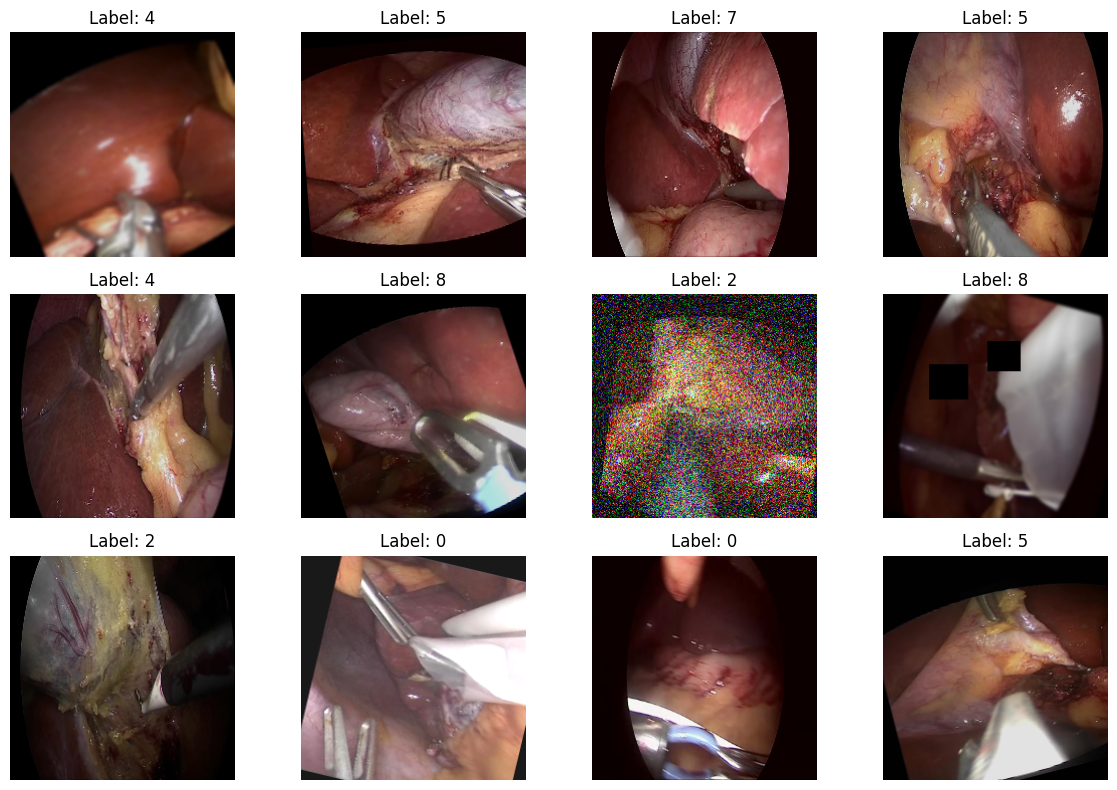

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Map numeric labels back to class names if you have a mapping
class_names = [str(i) for i in np.unique(Y_balanced_mapped)]

# Randomly select a few indices
indices = np.random.choice(len(X_balanced), size=12, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 4, i+1)
    img = X_balanced[idx]

    # If values are [0,1], scale to [0,255] for display
    plt.imshow((img * 255).astype(np.uint8))
    plt.title(f"Label: {class_names[Y_balanced_mapped[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Class distribution after balancing:
Class 0: 265 samples
Class 1: 265 samples
Class 2: 265 samples
Class 3: 265 samples
Class 4: 265 samples
Class 5: 265 samples
Class 6: 265 samples
Class 7: 258 samples
Class 8: 265 samples


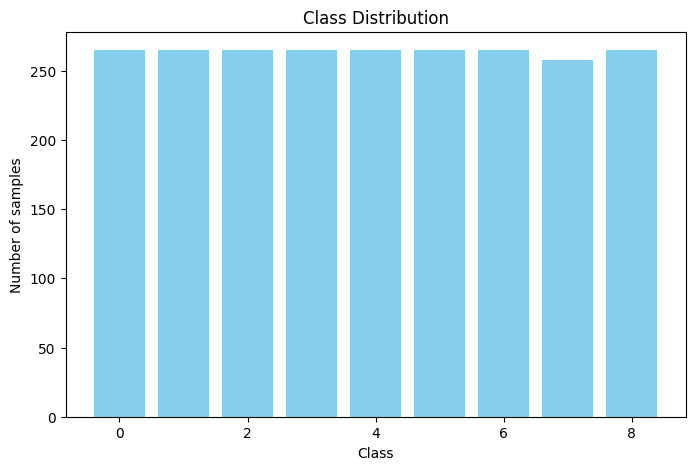

In [ ]:
from collections import Counter
import numpy as np

# Check unique labels and their counts
class_counts = Counter(Y_balanced_mapped)
print("Class distribution after balancing:")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} samples")

# Optionally, visualize as a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

Model Building

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf

num_classes = len(np.unique(Y_train))
inputs = Input(shape=(224, 224, 3))

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("Data type:", X_train.dtype)
print("Shape:", X_train.shape)
print("Min pixel value:", np.min(X_train))
print("Max pixel value:", np.max(X_train))
print("Mean pixel value:", np.mean(X_train))

Data type: float32
Shape: (1664, 224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.26621607


In [ ]:
print("Data type:", X_val.dtype)
print("Shape:", X_val.shape)
print("Min pixel value:", np.min(X_val))
print("Max pixel value:", np.max(X_val))
print("Mean pixel value:", np.mean(X_val))

Data type: float32
Shape: (357, 224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.26519346


In [ ]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(np.unique(Y_train))
print(np.unique(Y_val))

(1664, 224, 224, 3) (1664,)
(357, 224, 224, 3) (357,)
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


Label: 5


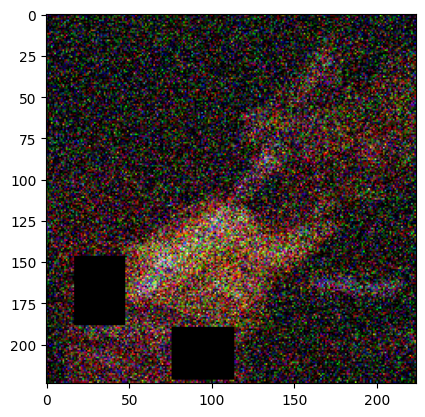

In [ ]:
import matplotlib.pyplot as plt
idx = np.random.randint(len(X_train))
plt.imshow(X_train[idx])
print("Label:", Y_train[idx])

In [ ]:
print(np.unique(Y_train))

[0 1 2 3 4 5 6 7 8]


In [ ]:
print(Y_train[:5])

[7 4 8 6 8]


Train: (1664, 224, 224, 3) (1664,)
Val: (357, 224, 224, 3) (357,)
Unique train labels: [0 1 2 3 4 5 6 7 8]
Unique val labels: [0 1 2 3 4 5 6 7 8]


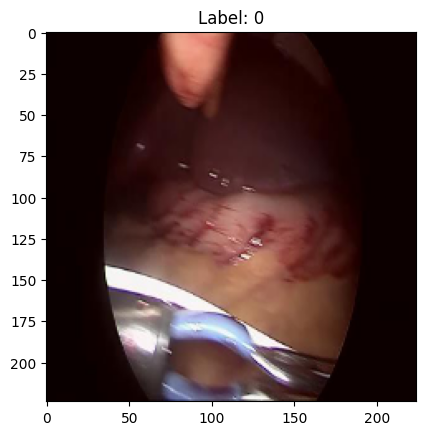

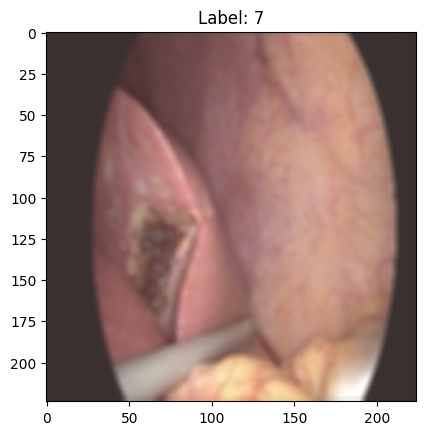

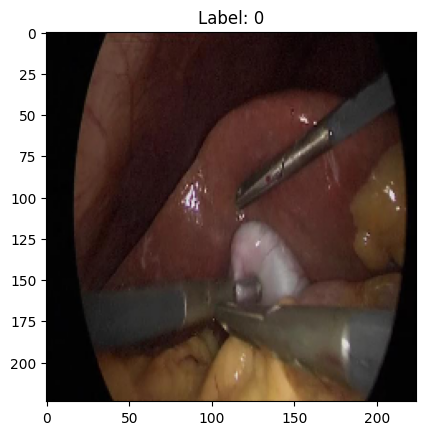

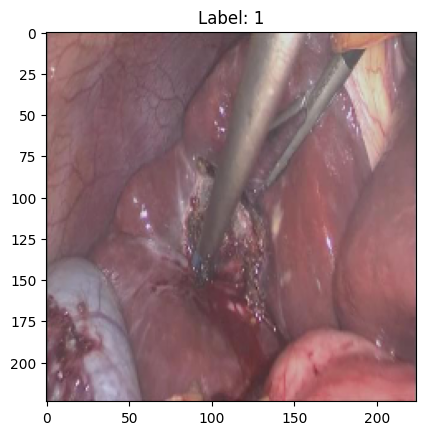

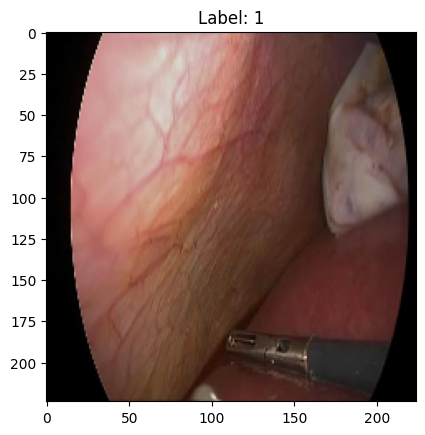

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("Train:", X_train.shape, Y_train.shape)
print("Val:", X_val.shape, Y_val.shape)
print("Unique train labels:", np.unique(Y_train))
print("Unique val labels:", np.unique(Y_val))

idxs = np.random.choice(len(X_train), 5)
for i in idxs:
    plt.imshow(X_train[i])
    plt.title(f"Label: {Y_train[i]}")
    plt.show()